# Pre-Processing

## Imports

In [2]:
import pandas as pd
import numpy as np
import re
import string
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from pickle import dump, load

## 

In [3]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r', encoding="utf8")
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [4]:
# turn a doc into clean tokens
def clean_doc(df):
	# lower case
    df.Text_data = df.Text_data.str.lower()
    # remove url/website that didn't use http, is only checking for .com websites  so words that are seperated by a . are not removed
    df.Text_data = df.Text_data.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
    # remove @mention
    df.Text_data = df.Text_data.apply(lambda x: re.sub(r'@mention', '', x))
    # remove {link}
    df.Text_data = df.Text_data.apply(lambda x: re.sub(r'{link}', '', x))
    # remove &text; html chars
    df.Text_data = df.Text_data.apply(lambda x: re.sub(r'&[a-z]+;', '', x))
    # [video]
    df.Text_data = df.Text_data.apply(lambda x: re.sub(r"\[video\]", '', x))
    # remove all remaining characters that aren't letters, white space, or the following #:)(/\='] that are used in emojis or hashtags
    df.Text_data = df.Text_data.apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))
	# remove stop words
    #stop_words = set(stopwords.words('english'))
    #df['Text_data'] = df['Text_data'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))  
    return df

In [5]:
# save a dataset to file
def save_dataset(dataset, filename):
	dump(dataset, open(filename, 'wb'))
	print('Saved: %s' % filename)

In [6]:
# load Dataset
df = pd.read_csv('Dataset/Dataset.tsv',sep='\t' )


In [7]:
# Drop PID column
df = df.drop('PID', axis=1)

In [8]:
# Encode labels
df['Label']=df['Label'].map({'not depression': 0, 'moderate': 1, 'severe': 2}).astype(int)

In [9]:
# Clean Dataset
df = clean_doc(df)

In [10]:
df

,Text_data,Label
0,waiting for my mind to have a breakdown once t...,1
1,my new years resolution : i'm gonna get my ass...,1
2,new year : somone else feeling like will be t...,1
3,my story i guess : hi im from germany and my e...,1
4,sat in the dark and cried myself going into th...,1
...,...,...
8886,ways to reverse memory loss from depression : ...,2
8887,a comprehensive guide to slowly getting better...,2
8888,i dont think college is right for me : tw: sui...,2
8889,please help: severe insomnia affecting me in m...,2


## OverSampling the train set

In [11]:
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(df['Text_data'], df['Label'], test_size=0.25, random_state=42, stratify=df['Label'])

In [12]:
# Convert the test set into a DataFrame
df_train  = pd.DataFrame({'Text_data': X_train, 'Label': Y_train})

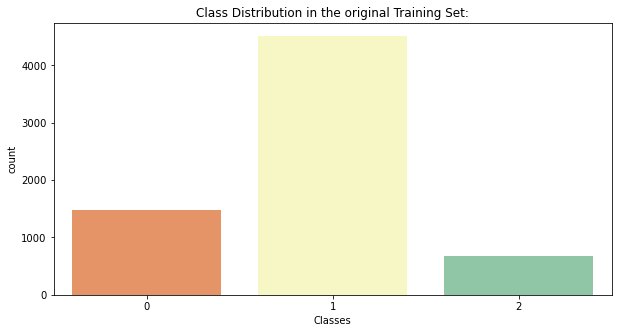

In [13]:
# Plot the class distribution for the original training set
plt.figure(figsize=(10, 5))
sns.countplot(data=df_train, x='Label', palette='Spectral')
plt.xlabel('Classes')
plt.title('Class Distribution in the original Training Set:')
plt.show()

In [11]:
# Oversampling the training set only
ros = RandomOverSampler(random_state=42)
X_train_res, Y_train_res = ros.fit_resample(X_train.values.reshape(-1, 1), Y_train.values)

In [12]:
# Convert the resampled arrays back to a DataFrame
df_train_resampled = pd.DataFrame({'Text_data': X_train_res.flatten(), 'Label': Y_train_res.flatten()})


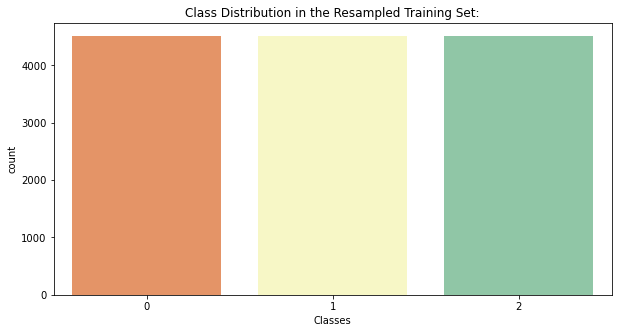

In [13]:
# Plot the class distribution for the resampled training set
plt.figure(figsize=(10, 5))
sns.countplot(data=df_train_resampled, x='Label', palette='Spectral')
plt.xlabel('Classes')
plt.title('Class Distribution in the Resampled Training Set:')
plt.show()

In [14]:
# Convert the test set into a DataFrame
df_test  = pd.DataFrame({'Text_data': X_test, 'Label': Y_test})

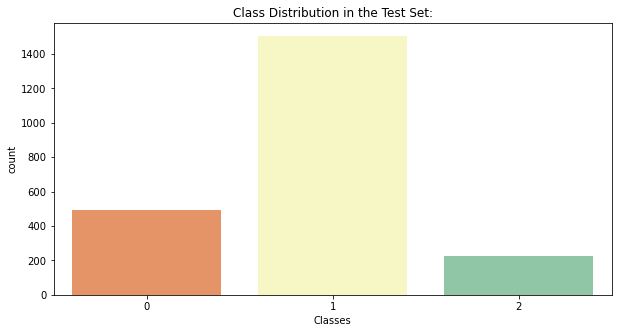

In [15]:
# Plot the class distribution in the original test set
plt.figure(figsize=(10, 5))
sns.countplot(data=df_test, x='Label', palette='Spectral')
plt.xlabel('Classes')
plt.title('Class Distribution in the Test Set:')
plt.show()

## Save the pre-processed train and test sets as pickle files 

In [16]:
save_dataset([df_train_resampled['Text_data'],df_train_resampled['Label']], 'Dataset/train.pkl')
save_dataset([df_test['Text_data'],df_test['Label']], 'Dataset/test.pkl')

Saved: Dataset/train.pkl
Saved: Dataset/test.pkl
